# Accuracy of BlueSTARR-predicted effects of mutation: AUC

The idea here is to assess the accuracy of BlueSTARR model predictions by comparing its predicted effects of mutations to some sort of ground-truth data. Here we will be using variant effect calls using **B**ayesian **I**nference of **R**egulatory **D**ifferences ([BIRD](http://www.geneprediction.org/bird/)) to determine variants with a high probability of having a transcriptional effect (positive or negative).

## Setup

### Imports

In [2]:
import polars as pl
import numpy as np
import pandas as pd
import duckdb
from pathlib import Path

### Paths to data and databases

In [3]:
PROJECT_ROOT = Path('/hpc/group/igvf')
DATA_ROOT = Path("../../igvf-pm")
DB_ROOT = PROJECT_ROOT / 'db'
MUT_PRED_DB = DB_ROOT / 'cCRE-preds-K562'
BIRD_DIR = DATA_ROOT / "kd259"
BIRD_FILE = BIRD_DIR / "out.all.txt"
BIRD_COUNTS = BIRD_DIR / "BIRD_files" / "BIRD_input.K562.2024_07_18.txt"

## Load BIRD calls and BIRD input read counts

### BIRD calls

The columns in the file with BIRD calls are:
1. Variant ID = identifier of the variant tested, formatted as chrom:pos:ref:alt. Note that the variant position is a 1-based coordinate.
2. Effect size (theta) = posterior median of effect size under the model.  This effect size can be interpreted as the transcriptional rate of the alternate allele divided by the transcriptional rate of the reference allele.  An effect of 0.5 means that the alternate allele halves the transcriptional rate.  Effect sizes tend to be between 0.5 and 2 for real regulatory variants.  An effect size close to 1 means no effect.
3. Lower CI = lower bound of 95% credible interval.
4. Upper CI = upper bound of 95% credible interval.
5. $P_{reg}$ = posterior probability that the variant has a regulatory effect.  This probability reflects the lambda value specified in the BIRD command.  If you specified 1.25 (as recommended), $P_{reg}$ will be the posterior probability that the effect size is greater than 1.25 or less than 1/1.25.


In [4]:
pred_table = pl.scan_csv(BIRD_FILE, separator="\t", has_header=False,
                         new_columns=["variantID", "theta", "lowerCI", "upperCI", "P_reg"])


In [5]:
bird_calls = pred_table.with_columns(
    pl.col('variantID').str.split(':')
    .list.to_struct(fields=['chrom', 'allele_pos','ref_allele','alt_allele'])
).unnest('variantID').filter(
    pl.col('ref_allele').str.len_bytes() == 1,
    pl.col('alt_allele').str.len_bytes() == 1
).with_columns(
    pl.col('allele_pos').cast(pl.UInt32).add(-1),
)

### BIRD input read counts

BIRD calls are computed from input read counts for DNA (_input_) and RNA (_output_) replicates. It is possible to obtain a $P_{reg}\leq t$ for a "true negative" threshold _t_ _"simply because of the shrinkage prior overwhelming the data when read counts are low."_

We therefore include the read counts that served as input to BIRD, so we can threshold on those values, too. Specifically, we compute the average input read counts for both the reference and the alternate allele.

#### Determine column names

The columns of the read counts file are variable and are determined by the number of DNA ("input") and RNA ("output") replicates. Specifically, the are in the following order (example for 3 replicates for both DNA and RNA):
- Variant ID (chrom:pos:ref:alt with 1-based pos)
- Input replicate count
- Input 1 reference count
- Input 1 alternate count
- Input 2 reference count
- Input 2 alternate count
- Input 3 reference count
- Input 3 alternate count
- Output replicate count
- Output 1 reference count
- Output 1 alternate count
- Output 2 reference count
- Output 2 alternate count
- Output 3 reference count
- Output 3 alternate count

To determine the names for columns after the input replicate count, we take a peek at the file, and then compute names from the number of replicates.

In [6]:
peek = pd.read_csv(BIRD_COUNTS, sep='\t', header=None, nrows=50, na_values='NA')
inputs_count = peek[1].unique()
if len(inputs_count) > 1:
    raise ValueError(f"Expected a single unique input count, got {inputs_count}")
outputs_count = peek[2 + 2*inputs_count[0]].unique()
if len(outputs_count) > 1:
    raise ValueError(f"Expected a single unique output count, got {outputs_count}")
colnames = (
    ['variantID', 'n_inputs'] + 
    [f"input{i}_{suffix}" for i in range(1, inputs_count[0] + 1) for suffix in ("ref", "alt")] + 
    ['n_outputs'] +
    [f"output{i}_{suffix}" for i in range(1, outputs_count[0] + 1) for suffix in ("ref", "alt")]
)
# some columns have many NA values, so to we need to force them as integers so they aren't floats
dtypes = [pl.String] + [pl.UInt32] * (len(colnames) - 1)

#### Parse and process counts file

We add a number of computed columns. These are more straightforward to add here rather than in a SQL query because they compute across (horizontally) columns best identified by regular expression.

In [7]:
bird_counts = pl.scan_csv(BIRD_COUNTS, separator='\t', has_header=False,
                          new_columns=colnames, schema_overrides=dtypes,
                          null_values=['NA'])
bird_counts = bird_counts.with_columns(
    pl.col('variantID').str.split(':')
    .list.to_struct(fields=['chrom', 'allele_pos','ref_allele','alt_allele'])
).unnest('variantID').filter(
    pl.col('ref_allele').str.len_bytes() == 1,
    pl.col('alt_allele').str.len_bytes() == 1
).with_columns(
    pl.col('allele_pos').cast(pl.UInt32).add(-1),
).drop_nans().with_columns(
    avg_input_ref=pl.mean_horizontal(pl.col("^input[0-9]+_ref$")),
    avg_input_alt=pl.mean_horizontal(pl.col("^input[0-9]+_alt$")), 
    avg_output_ref=pl.mean_horizontal(pl.col("^output[0-9]+_ref$")),
    avg_output_alt=pl.mean_horizontal(pl.col("^output[0-9]+_alt$")),
).with_columns(
    min_avg_count=pl.min_horizontal(pl.col("^avg_(input|output).*$")),
    naive_theta=(pl.col('avg_output_alt') / pl.col('avg_output_ref')) / (pl.col('avg_input_alt') / pl.col('avg_input_ref')),
)

## Merge with BlueSTARR mutation predictions

### Database with BlueSTARR predictions from saturated mutagenesis of cCREs

In [8]:
mutpreds = duckdb.read_parquet(str(DB_ROOT / f'{MUT_PRED_DB}/**/*.parquet'), hive_partitioning=True)


### Join by chromosomal position and alternative allele

We include the reference allele as a sanity check. Including it in the join conditions in theory would be redundant with joining by chromosomal position. By omitting it from te join conditions, we can check that indeed the reference alleles are the same from both tables.

In [9]:
blue_birds = duckdb.sql(
    "select b.chrom, m.allele_pos, b.ref_allele, b.alt_allele, b.theta, b.lowerCI, b.upperCI, b.p_reg, "
    "m.ref_allele as blue_ref_allele, m.log2FC, c.avg_input_ref, c.min_avg_count "
    "from bird_calls b, mutpreds m, bird_counts c "
    "where b.chrom = m.chrom and b.chrom = c.chrom "
    "and b.allele_pos = m.allele_pos and b.allele_pos = c.allele_pos "
    "and b.alt_allele = m.allele and b.alt_allele = c.alt_allele")

It's not necessary for the ROC curve analysis, but to make sanity inspection easier we order by chromosomal position and alt allele. 

In [11]:
bb_df = blue_birds.df().sort_values(['chrom', 'allele_pos', 'alt_allele'])

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [12]:
bb_df

,chrom,allele_pos,ref_allele,alt_allele,theta,lowerCI,upperCI,P_reg,blue_ref_allele,log2FC,avg_input_ref,min_avg_count
132523,chr1,139057,C,G,0.988454,0.758482,1.240670,0.054,C,0.008718,98.333333,21.333333
132527,chr1,181392,G,C,1.030300,0.798790,1.495150,0.132,G,-0.032558,40.000000,11.000000
132524,chr1,181468,G,A,0.487996,0.261877,0.901602,0.927,G,-0.002900,55.000000,8.000000
132525,chr1,181507,G,C,0.928912,0.582267,1.181070,0.206,G,-0.004882,63.000000,11.666667
132526,chr1,181569,G,A,0.937604,0.314720,1.467280,0.290,G,-0.004441,79.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
129819,chr9,138050483,G,C,0.898340,0.490950,1.162150,0.315,G,-0.008928,33.000000,5.000000
129820,chr9,138071420,C,T,1.011670,0.783840,1.504290,0.092,C,-0.004002,18.666667,13.666667
129821,chr9,138098192,T,A,0.434455,0.114793,1.063190,0.790,T,0.041753,42.000000,0.666667
129822,chr9,138098495,G,A,0.945288,0.471378,1.505700,0.225,G,-0.016944,3.666667,3.666667


Sanity check: for every position, the reference alleles between BIRD and BlueSTARR should be the same.

In [13]:
bb_df.loc[bb_df['ref_allele'] != bb_df['blue_ref_allele']]

,chrom,allele_pos,ref_allele,alt_allele,theta,lowerCI,upperCI,P_reg,blue_ref_allele,log2FC,avg_input_ref,min_avg_count


### Write matched table to file

In [15]:
bb_df.to_csv(DB_ROOT / 'blue_bird.csv.gz', index=False)

### Inspect BIRD and BlueSTARR estimates in light of underlying counts

Initially we don't filter out rows with $0.3 < P_{reg} < 0.9$ (which later will not be labeled as either TPs or TNs), so we can get more of a sense of how this transition from TN to TP looks.

We do, however, filter otherwise as we will for AUROC analysis. Specifically, we remove rows that don't have an average input and output reference read count for the reference and alternate allele, respectively, of at least 5; and we exclude from the prospective TN class ($P_{reg}$≤0.3) rows with an average input read count for the reference allele of less than 30.

In [14]:
theta_and_counts = duckdb.sql(
    "select bb.chrom, bb.allele_pos as pos, bb.ref_allele as ref, bb.alt_allele as alt, "
    "bb.log2FC as BlueSTARR_log2FC, "
    "log2(bb.theta) as BIRD_log2Theta, "
    "log2(c.naive_theta) as BIRD_log2naivetheta, "
    "bb.p_reg, "
    "c.input1_ref, c.input1_alt, c.input2_ref, c.input2_alt, c.input3_ref, c.input3_alt, "
    "c.output1_ref, c.output1_alt, c.output2_ref, c.output2_alt, c.output3_ref, c.output3_alt "
    "from blue_birds bb, bird_counts c "
    "where bb.chrom = c.chrom and bb.allele_pos = c.allele_pos and bb.alt_allele = c.alt_allele "
    "and (bb.p_reg > 0.3 or (bb.p_reg <= 0.3 and bb.avg_input_ref >= 30)) "
    "and c.min_avg_count >= 5 "
    "order by bb.p_reg desc, abs(BIRD_log2Theta) desc").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Write to file so the counts can be inspected. We'll write one table for the TPs and one for TNs, and we'll use much stricter cutoffs for $P_{reg}$ than we would for the AUROC analysis, to keep file size down.

In [15]:
theta_and_counts.loc[theta_and_counts['P_reg'] > 0.99].to_csv(DB_ROOT / 'blue_bird_thetas_and_counts-TPs.tsv', 
                                                             index=False, sep='\t')
theta_and_counts.loc[theta_and_counts['P_reg'] < 0.1].iloc[::-1].to_csv(DB_ROOT / 'blue_bird_thetas_and_counts-TNs.tsv',
                                                                        index=False, sep='\t')

#### BIRD estimates vs naïve theta vs BlueSTARR predictions

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns

First we'll look at BIRD estimates vs naïve theta values including the transition of $0.3 < P_{reg} < 0.9$.

Text(0.5, 1.0, 'BIRD estimated vs naïve theta')

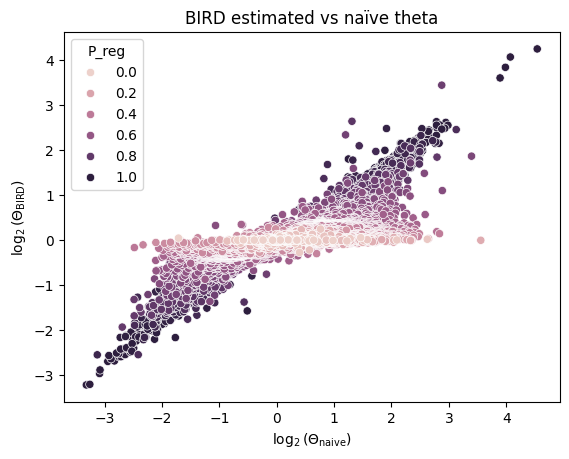

In [22]:
ax = sns.scatterplot(data=theta_and_counts, x='BIRD_log2naivetheta', y='BIRD_log2Theta', hue='P_reg')
ax.set(xlabel='$\log_2(\Theta_{\mathrm{naive}})$', ylabel='$\log_2(\Theta_{\mathrm{BIRD}})$')
ax.set_title('BIRD estimated vs naïve theta')

Then the same removing this transition region.

Text(0.5, 1.0, 'BIRD estimated vs naïve theta ($P_{reg}\\leq 0.3$ or $P_{reg} \\geq 0.9$)')

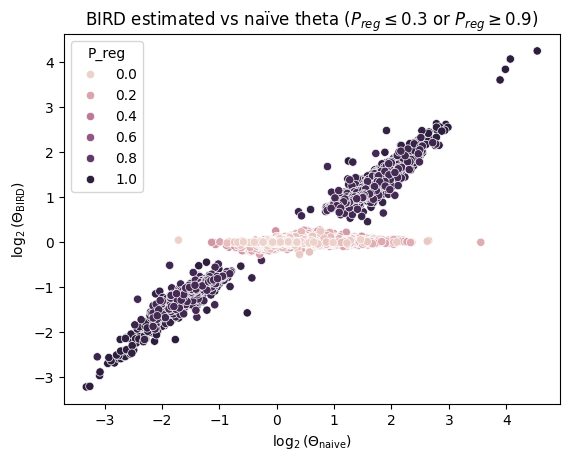

In [23]:
ax = sns.scatterplot(data=theta_and_counts.loc[(theta_and_counts['P_reg'] <= 0.3) | 
                                               (theta_and_counts['P_reg'] >= 0.9)], 
                     x='BIRD_log2naivetheta', y='BIRD_log2Theta', hue='P_reg')
ax.set(xlabel='$\log_2(\Theta_{\mathrm{naive}})$', ylabel='$\log_2(\Theta_{\mathrm{BIRD}})$')
ax.set_title('BIRD estimated vs naïve theta ($P_{reg}\leq 0.3$ or $P_{reg} \geq 0.9$)')

Text(0.5, 1.0, 'BlueSTARR predicted vs BIRD estimated theta ($P_{reg}\\leq 0.3$ or $P_{reg} \\geq 0.9$)')

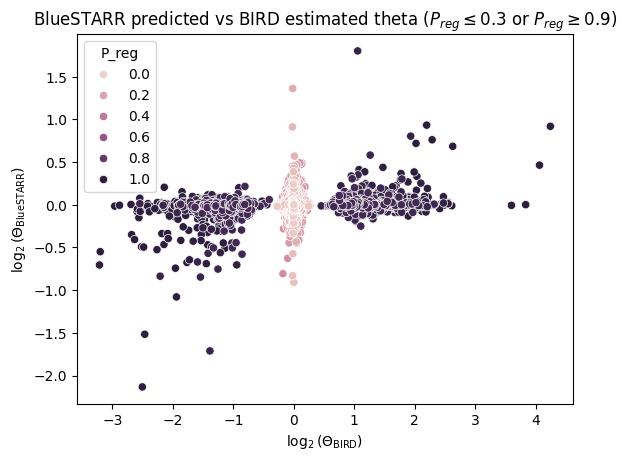

In [ ]:
ax = sns.scatterplot(data=theta_and_counts.loc[(theta_and_counts['P_reg'] <= 0.3) | 
                                               (theta_and_counts['P_reg'] >= 0.9)], 
                     x='BIRD_log2Theta', y='BlueSTARR_log2FC', hue='P_reg')
ax.set(xlabel='$\log_2(\Theta_{\mathrm{BIRD}})$', ylabel='$\log_2(\Theta_{\mathrm{BlueSTARR}})$')
ax.set_title('BlueSTARR predicted vs BIRD estimated theta ($P_{reg}\leq 0.3$ or $P_{reg} \geq 0.9$)')

Text(0.5, 1.0, 'BlueSTARR predicted vs BIRD naïve theta ($P_{reg}\\leq 0.3$ or $P_{reg} \\geq 0.9$)')

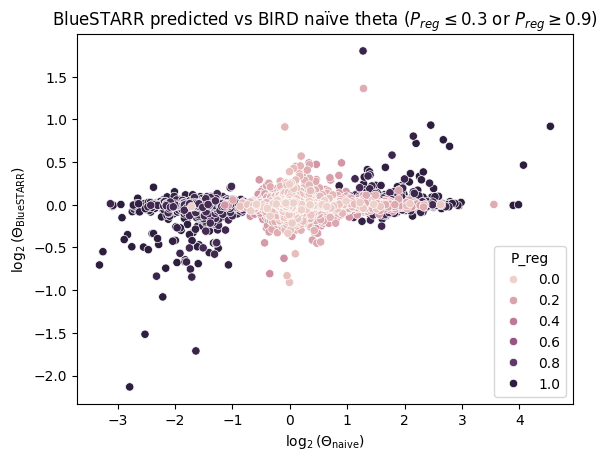

In [47]:
ax = sns.scatterplot(data=theta_and_counts.loc[(theta_and_counts['P_reg'] <= 0.3) | 
                                               (theta_and_counts['P_reg'] >= 0.9)], 
                     x='BIRD_log2naivetheta', y='BlueSTARR_log2FC', hue='P_reg')
ax.set(xlabel='$\log_2(\Theta_{\mathrm{naive}})$', ylabel='$\log_2(\Theta_{\mathrm{BlueSTARR}})$')
ax.set_title('BlueSTARR predicted vs BIRD naïve theta ($P_{reg}\leq 0.3$ or $P_{reg} \geq 0.9$)')

## ROC display and AUC

### Define positive and negative classes

We define the positive class as variants with $P_{reg}$ greater than some threshold, and the negative class as variants with $P_{reg}$ less than some threshold.

In [16]:
Preg_pos = 0.9
Preg_neg = 0.3

In [17]:
pos_label = f"BIRD P_reg ≥ {Preg_pos}"
neg_label = f"BIRD P_reg ≤ {Preg_neg}"
bb_df['label'] = None
bb_df.loc[bb_df['P_reg'] >= Preg_pos, 'label'] = pos_label
bb_df.loc[bb_df['P_reg'] <= Preg_neg, 'label'] = neg_label

#### Keep only variants with an average read count for any replicate group of at least 5

In [18]:
bb_df = bb_df.loc[bb_df['min_avg_count'] >= 5]

### Subset predictions into those with positive and negative effects

In [19]:
bb_df_pos = bb_df.loc[bb_df['label'].notna() & (bb_df['theta'] > 1)]
bb_df_neg = bb_df.loc[bb_df['label'].notna() & (bb_df['theta'] < 1)]

How many positives and negatives do we have?

In [20]:
bb_df_pos.value_counts('label')

label
BIRD P_reg ≤ 0.3    45344
BIRD P_reg ≥ 0.9     1967
Name: count, dtype: int64

In [21]:
bb_df_neg.value_counts('label')

label
BIRD P_reg ≤ 0.3    44897
BIRD P_reg ≥ 0.9     1996
Name: count, dtype: int64

### ROC curve display and AUC calculation

In [22]:
from sklearn.metrics import RocCurveDisplay

Allow subsetting all classes or only the TN class by minimum average input reference count:

In [23]:
def subset_by_avg_input(df, min_avg_input, pos_label=None, neg_label=None):
    if pos_label is None:
        return df.loc[df['avg_input_ref'] >= min_avg_input]
    else:
        return df.loc[((df['avg_input_ref'] >= min_avg_input) & (df['label'] == neg_label)) |
                      (df['label'] == pos_label)]

For now, we subset _only_ the TN class by minimum average input reference read count. We consider different thresholds: 

In [27]:
bb_df_pos_gt10 = subset_by_avg_input(bb_df_pos, 10, pos_label=pos_label, neg_label=neg_label)
bb_df_neg_gt10 = subset_by_avg_input(bb_df_neg, 10, pos_label=pos_label, neg_label=neg_label)
bb_df_pos_gt30 = subset_by_avg_input(bb_df_pos, 30, pos_label=pos_label, neg_label=neg_label)
bb_df_neg_gt30 = subset_by_avg_input(bb_df_neg, 30, pos_label=pos_label, neg_label=neg_label)

Text(0.5, 1.0, 'BlueSTARR effect prediction accuracy')

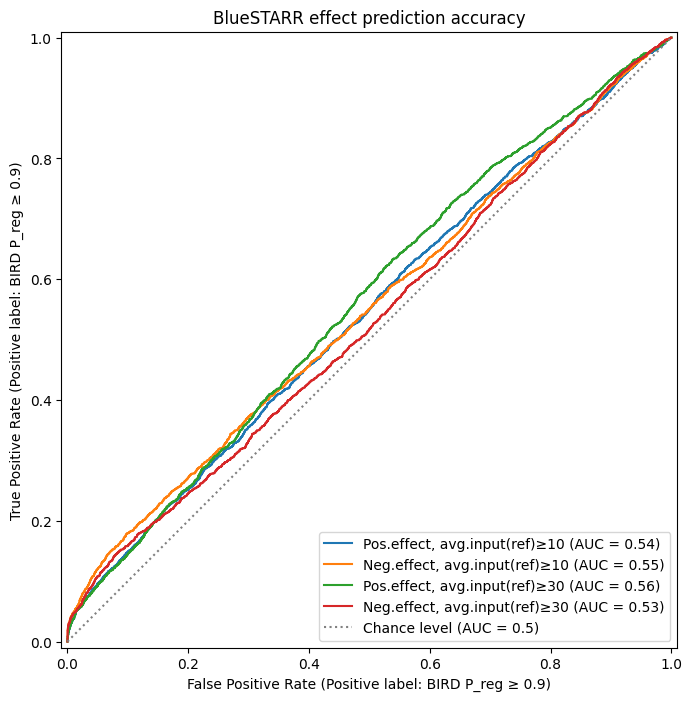

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
roc_pos = RocCurveDisplay.from_predictions(
    bb_df_pos_gt10['label'],
    bb_df_pos_gt10['log2FC'], pos_label=pos_label,
    name='Pos.effect, avg.input(ref)≥10', ax=ax)
roc_neg = RocCurveDisplay.from_predictions(
    bb_df_neg_gt10['label'],
    -bb_df_neg_gt10['log2FC'], pos_label=pos_label,
    name='Neg.effect, avg.input(ref)≥10', ax=ax)
roc_pos = RocCurveDisplay.from_predictions(
    bb_df_pos_gt30['label'],
    bb_df_pos_gt30['log2FC'], pos_label=pos_label,
    name='Pos.effect, avg.input(ref)≥30', ax=ax)
roc_neg = RocCurveDisplay.from_predictions(
    bb_df_neg_gt30['label'],
    -bb_df_neg_gt30['log2FC'], pos_label=pos_label,
    name='Neg.effect, avg.input(ref)≥30', ax=ax,
    plot_chance_level=True, chance_level_kw={'linestyle': 'dotted', 'linewidth': 1.5, 'color': 'gray'})
ax.set_title('BlueSTARR effect prediction accuracy')


### Compare input read count filtering to random filtering

The classes defined by $P_{reg}\geq 0.9$ and $P_{reg}\leq 0.3$ are highly imbalanced. If we apply minimum input read count filtering only to one class (the no effect class), the change in AUC might be caused simply by changing the imbalance. Therefore, here we compare the input read count-based filtering of only one classe to a random filtering of only that same class. 

In [29]:
def subset_random(df, sample_prob, subset_class=None, other_class=None):
    x = np.random.rand(len(df))
    return df.loc[((x < sample_prob) & (df['label'] == subset_class)) |
                   (df['label'] == other_class)]

In [30]:
bb_df_pos_rand = subset_random(bb_df_pos, 0.1, other_class=pos_label, subset_class=neg_label)
bb_df_neg_rand = subset_random(bb_df_neg, 0.1, other_class=pos_label, subset_class=neg_label)

In [31]:
bb_df_pos_rand.value_counts('label')

label
BIRD P_reg ≤ 0.3    4609
BIRD P_reg ≥ 0.9    1967
Name: count, dtype: int64

In [32]:
bb_df_neg_rand.value_counts('label')

label
BIRD P_reg ≤ 0.3    4478
BIRD P_reg ≥ 0.9    1996
Name: count, dtype: int64

Text(0.5, 1.0, 'BlueSTARR effect prediction accuracy')

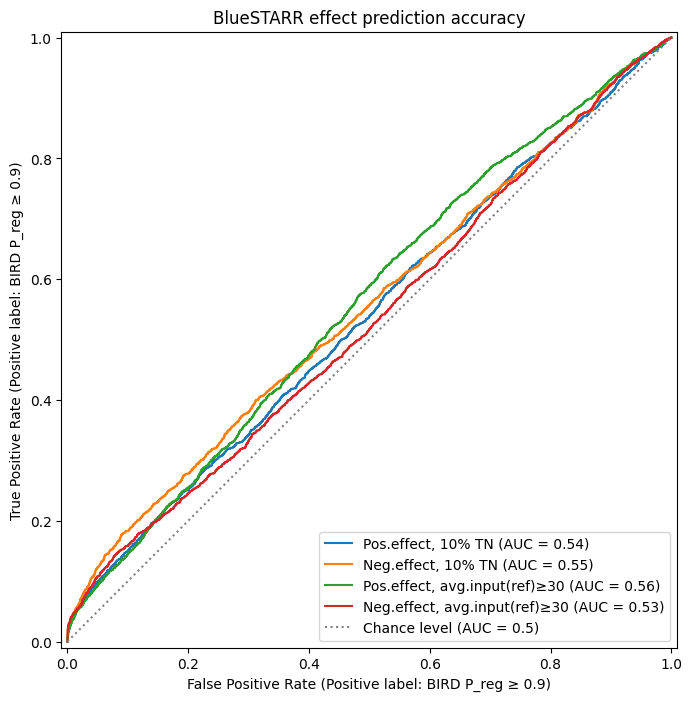

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
roc_pos = RocCurveDisplay.from_predictions(
    bb_df_pos_rand['label'],
    bb_df_pos_rand['log2FC'], pos_label=pos_label,
    name='Pos.effect, 10% TN', ax=ax)
roc_neg = RocCurveDisplay.from_predictions(
    bb_df_neg_rand['label'],
    -bb_df_neg_rand['log2FC'], pos_label=pos_label,
    name='Neg.effect, 10% TN', ax=ax)
roc_pos = RocCurveDisplay.from_predictions(
    bb_df_pos_gt30['label'],
    bb_df_pos_gt30['log2FC'], pos_label=pos_label,
    name='Pos.effect, avg.input(ref)≥30', ax=ax)
roc_neg = RocCurveDisplay.from_predictions(
    bb_df_neg_gt30['label'],
    -bb_df_neg_gt30['log2FC'], pos_label=pos_label,
    name='Neg.effect, avg.input(ref)≥30', ax=ax,
    plot_chance_level=True, chance_level_kw={'linestyle': 'dotted', 'linewidth': 1.5, 'color': 'gray'})
ax.set_title('BlueSTARR effect prediction accuracy')
